# Fire or No Fire?

In this miniproject you will attempt to identify fires from aerial vehicle cameras.

From the dataset creators, "Wildfires are one of the deadliest and dangerous natural disasters in the world. Wildfires burn millions of forests and they put many lives of humans and animals in danger. Predicting fire behavior can help firefighters to have better fire management and scheduling for future incidents and also it reduces the life risks for the firefighters. Recent advance in aerial images shows that they can be beneficial in wildfire studies. Among different methods and technologies for aerial images, Unmanned Aerial Vehicles (UAVs) and drones are beneficial to collect information regarding the fire."

## Dataset description

The data was obtained from flying an aerial vehicle over an area during a period of prescribed burning. The original data is in the form of a video, whilst here that video has been resized and split into individual frames. Given the nature of this dataset there is a lot of similarity between some of the images (e.g. neighbouring frames in the video). For further information about this dataset please see the [arxiv paper](https://arxiv.org/pdf/2012.14036.pdf)

## Machine learning tasks
1. Develop a machine learning classifier that can accurately perform the binary classification Fire vs No Fire
2. Develop a machine learning classifier that can accurately perform the ternary classification Fire vs No Fire vs Lake

## Optional extension tasks
1. Using your fire dataset develop a method of labeling which pixels are associated with the fire (using the segmentation data set)
2. Develop a method that label which pixels in the Fire vs No Fire dataset have fire in them.

### Things to think about
* What kind of data processing is appropriate?
* Should you split your traiing sample further to give a validation sample?
* What is an appropriate cost or loss function?
* Should you consider data augementation?
* Do you need to balance your data set in some way
* One of the optional tasks is based on image segmentation which most relies on network structures similar to autoencoders (but these days are often referred to as u-net structures).
* For the optional tasks you might take inspiration from the [Tensorflow Image Segmentation Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)

In [1]:
#Import standard libraries and imageio to read in the images
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds



In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [ ]:
def getImage(hasFire,whichImg):
    """Get one of the training images

    Keyword arguments:
    hasFire -- a boolean True/False
    whichImg -- the number of the image

    Returns:
    a tuple of label,image
    """
    if hasFire:
        label="Fire"
        filename='fireNoFire/Training/Fire/resized_frame'+str(whichImg)+'.jpg'
    else:
        label="No Fire"
        filename='fireNoFire/Training/No_Fire/resized_frame'+str(whichImg)+'.jpg'
        if not os.path.isfile(filename):
            label="No Fire Lake"
            filename='fireNoFire/Training/No_Fire/lake_resized_lake_frame'+str(whichImg)+'.jpg'

    return label,imageio.imread(filename) #Read and return the  image

The shape of the image is (254, 254, 3)


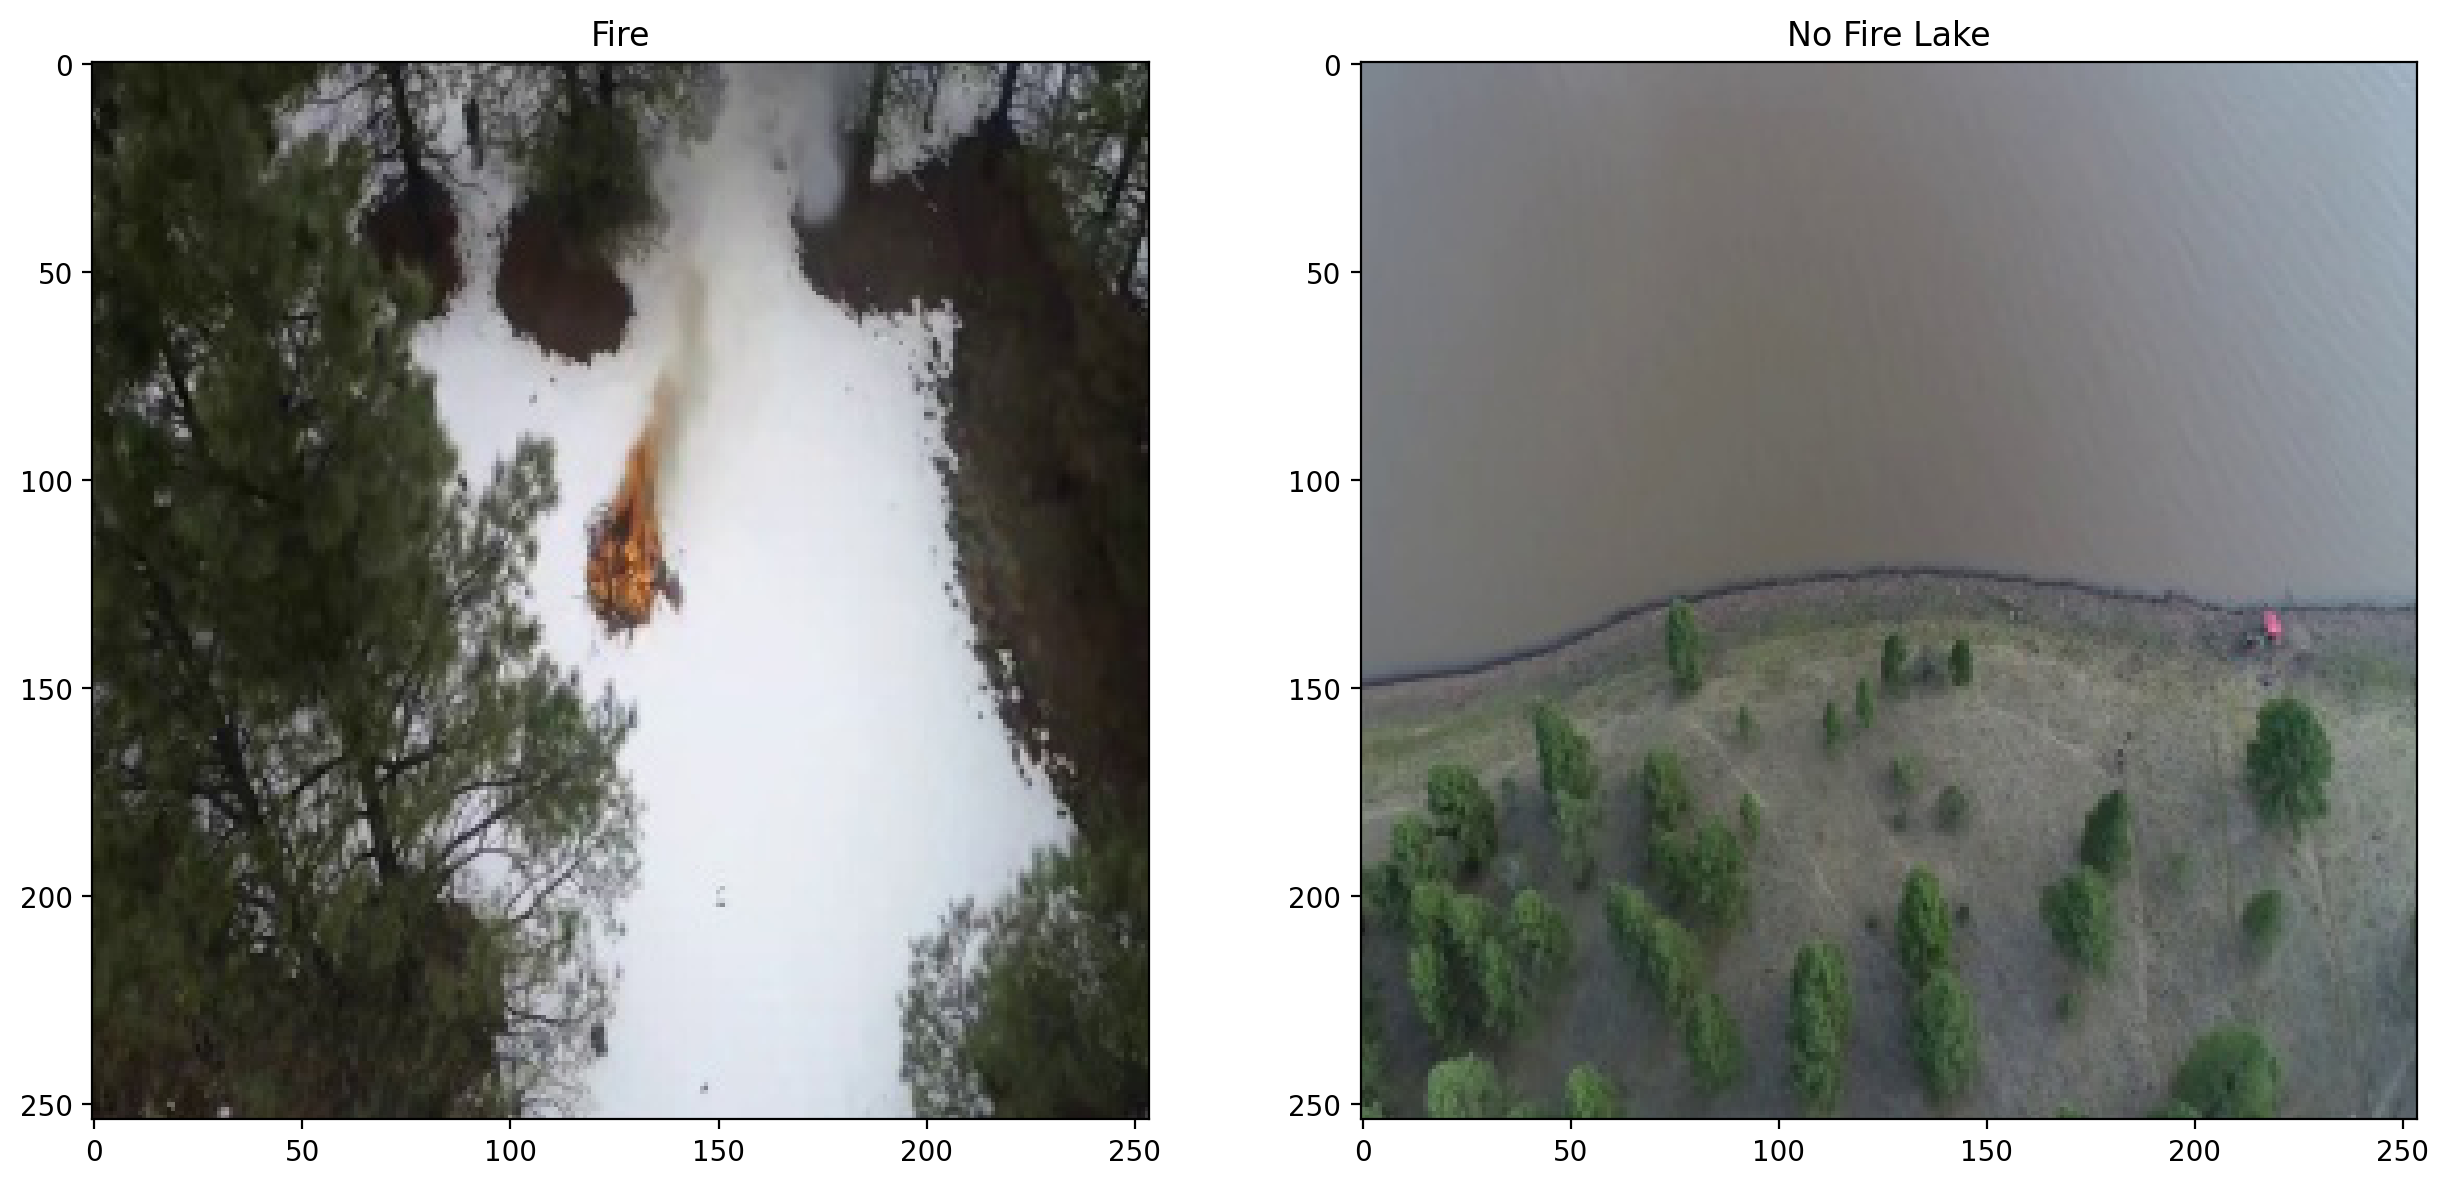

In [ ]:

fig,ax = plt.subplots(1,2,figsize=(15, 15)) #This fig size was convenient for my screen
label,im=getImage(True,0)
ax[0].imshow(im)
ax[0].set_title(label)
label,im=getImage(False,0)
ax[1].imshow(im)
ax[1].set_title(label)

print(f"The shape of the image is {im.shape}") #Print the shape of the image

## EDA

Having a Look at the training dataset for the classification tasks, it appears that a large portion of the No Fire images are mislabeled. A large portion of images which do not include a lake in them have been labeled as Lake images. I believe this is because these images were taken from a video which included some lake footage, so mistakenly every frame of that video was labeled as lake when some images were of a forest. I will have to relabel these images. This is not an issue for the first binary classification task but it will become an issue for the second tertiary classification.

After some inspection of the Fire training images, it also appears that some (but a small number) of images have also been mislabeled for the same reason. This I am slighly less certain of since it is difficult to see the fires in the images.

Let's have a look at how many images are in the training dataset and the testing dataset.


In [ ]:
def count_images_in_folder(folder_path):
    image_extensions = ('.jpg')
    count = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            count += 1

    return count

fire_train_path = 'fireNoFire/Training/Fire'
train_fire_count = count_images_in_folder(fire_train_path)
print(f'There are {train_fire_count} images in the Fire training folder.')

no_fire_train_path = 'fireNoFire/Training/No_Fire'
train_no_fire_count = count_images_in_folder(no_fire_train_path)
print(f'There are {train_no_fire_count} images in the No Fire training folder.')

fire_test_path = 'fireNoFire/Test/Fire'
test_fire_count = count_images_in_folder(fire_test_path)
print(f'There are {test_fire_count} images in the Fire test folder.')

no_fire_test_path = 'fireNoFire/Test/No_Fire'
test_no_fire_count = count_images_in_folder(no_fire_test_path)
print(f'There are {test_no_fire_count} images in the No Fire test folder.')




test_train_split = (test_fire_count + test_no_fire_count) / (train_fire_count + train_no_fire_count + test_fire_count + test_no_fire_count)
print(f'The test/train split is {test_train_split:.4f}.')



There are 25018 images in the Fire training folder.
There are 14357 images in the No Fire training folder.
There are 5137 images in the Fire test folder.
There are 3480 images in the No Fire test folder.
The test/train split is 0.1796.


There are fewer images in the No Fire testing folder which makes me want to create my own test/train split by randomly selecting the testing images from the pooled data. I may use their test/train split and also create a validation dataset from the training data to also include roughly 15% of the data. This way I would have a 15% test, 15% validation, 70% training split.

I want to investigate why they chose to split the training and testing dataset in this way. Maybe the testing dataset includes images from completely different videos to the training dataset to really have a difference between the datasets.

The Following code is following the binary classification example found at:

https://keras.io/examples/vision/image_classification_from_scratch/



## Filter out corrupted images

In [ ]:
def delete_corrupted(image_path):
    num_skipped = 0
    for folder_name in ("Fire", "No_Fire"):
        folder_path = os.path.join(image_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = b"JFIF" in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

    print(f"Deleted {num_skipped} images.")

#delete_corrupted('fireNoFire/Training')
#delete_corrupted('fireNoFire/Test')


This means none of the images are corrupted, wonderful!

In [ ]:
image_size = (254, 254)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "fireNoFire/Training",
    #labels="inferred",
    color_mode="rgb",
    validation_split=0.15,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)



Found 39375 files belonging to 2 classes.
Using 33469 files for training.
Using 5906 files for validation.


I don't understand where the 10000 images went. There should be 25000 images in Fire and 25000 images in No_Fire

Anyways, here are the first 9 images from the training set. The labels are inferred from the folder structure. 0 corresponds to "fire" images and 1 corresponds to "no fire" images

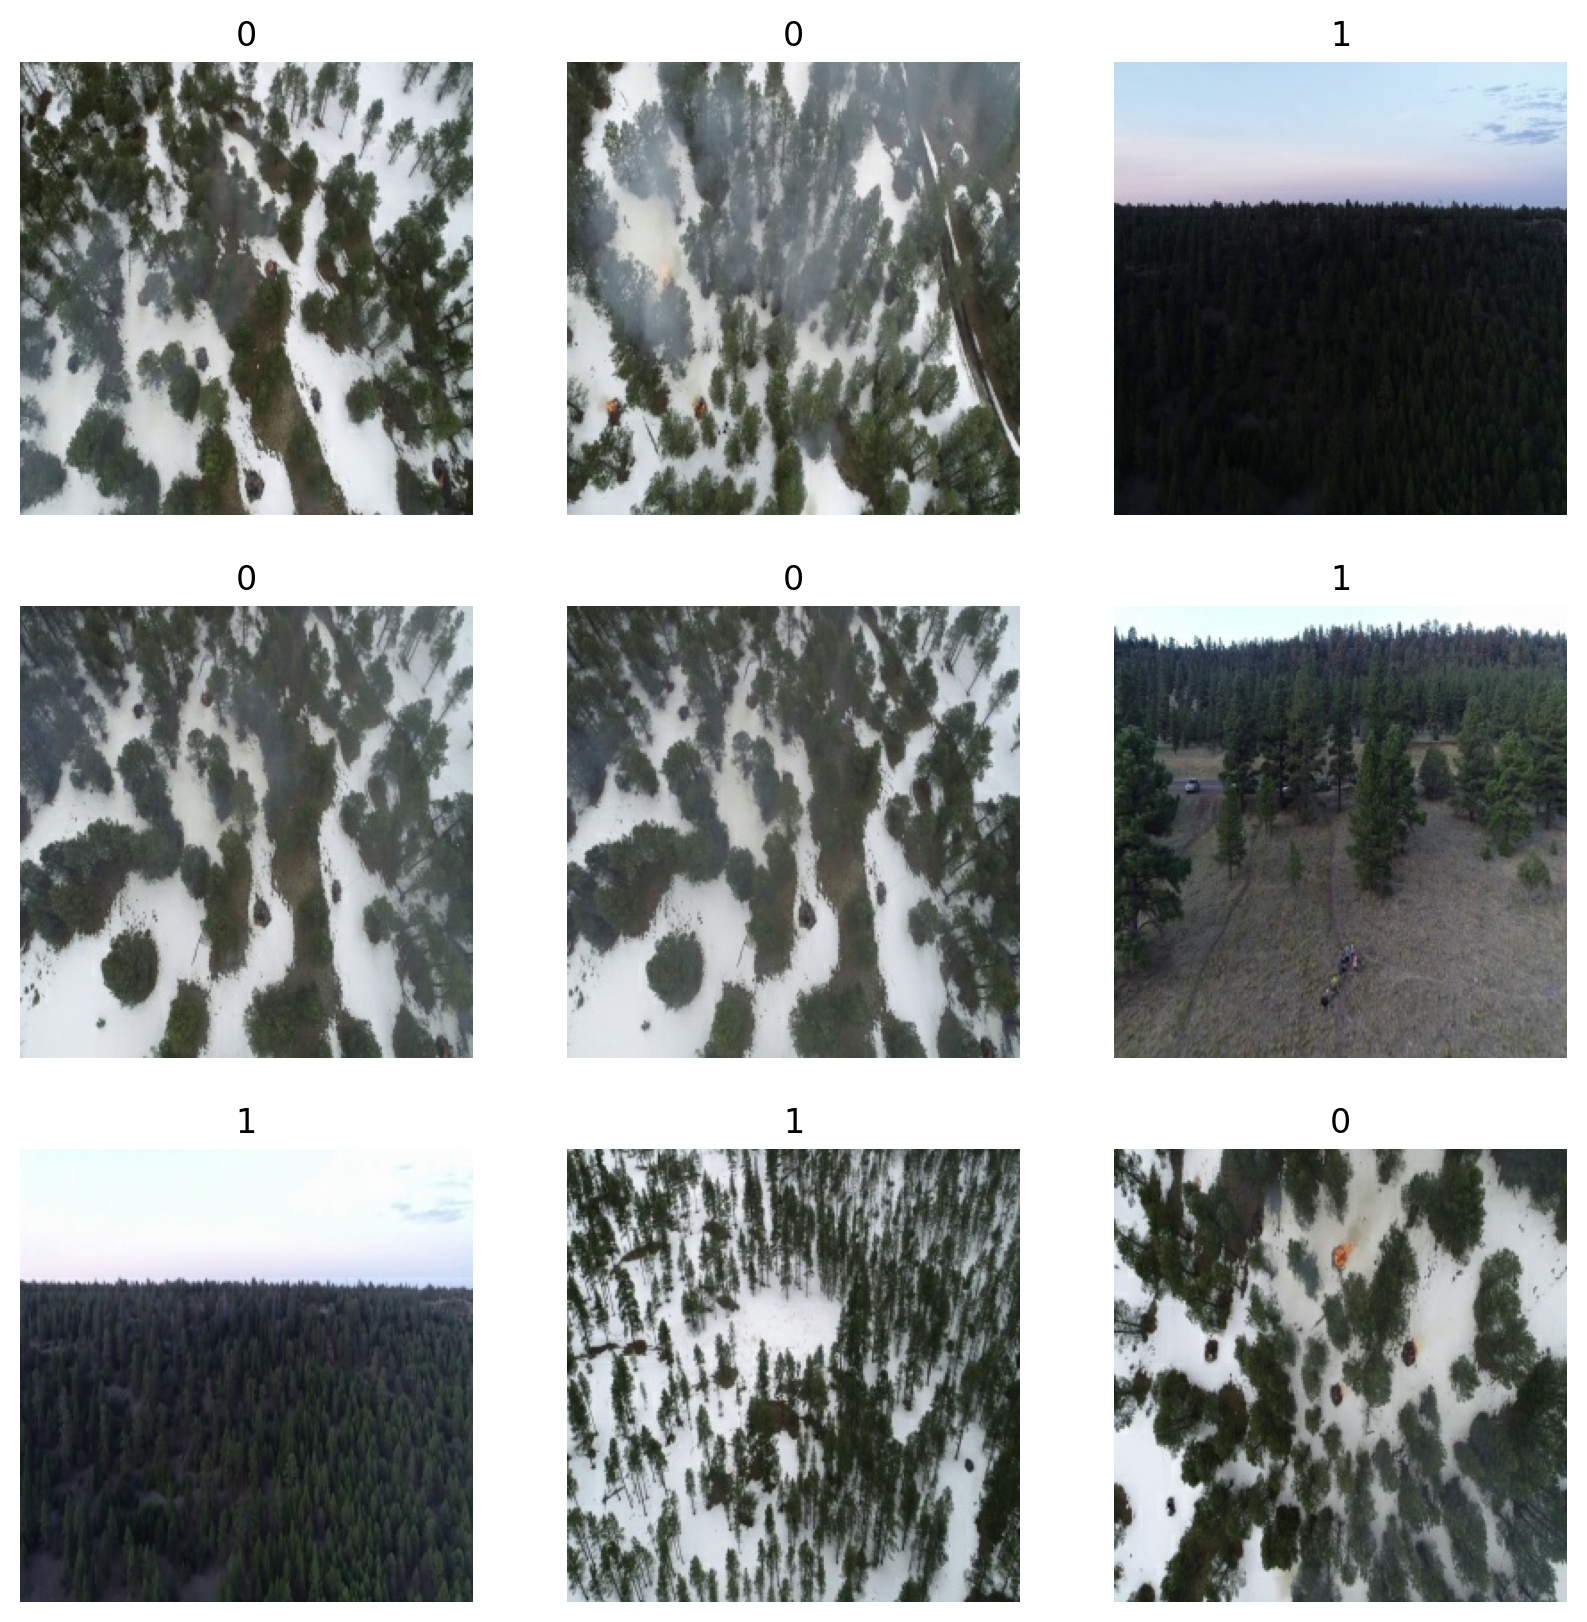

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data augmentation - rotating and flipping images

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"), #Randomly flip the image horizontally
    #layers.RandomContrast(0.2), #Randomly adjust the contrast of the image
    layers.RandomZoom(0.2), #Randomly zoom in on the image
    layers.RandomBrightness(0.1), #Randomly adjust the brightness
    layers.RandomRotation(0.1), #Randomly rotate the image
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

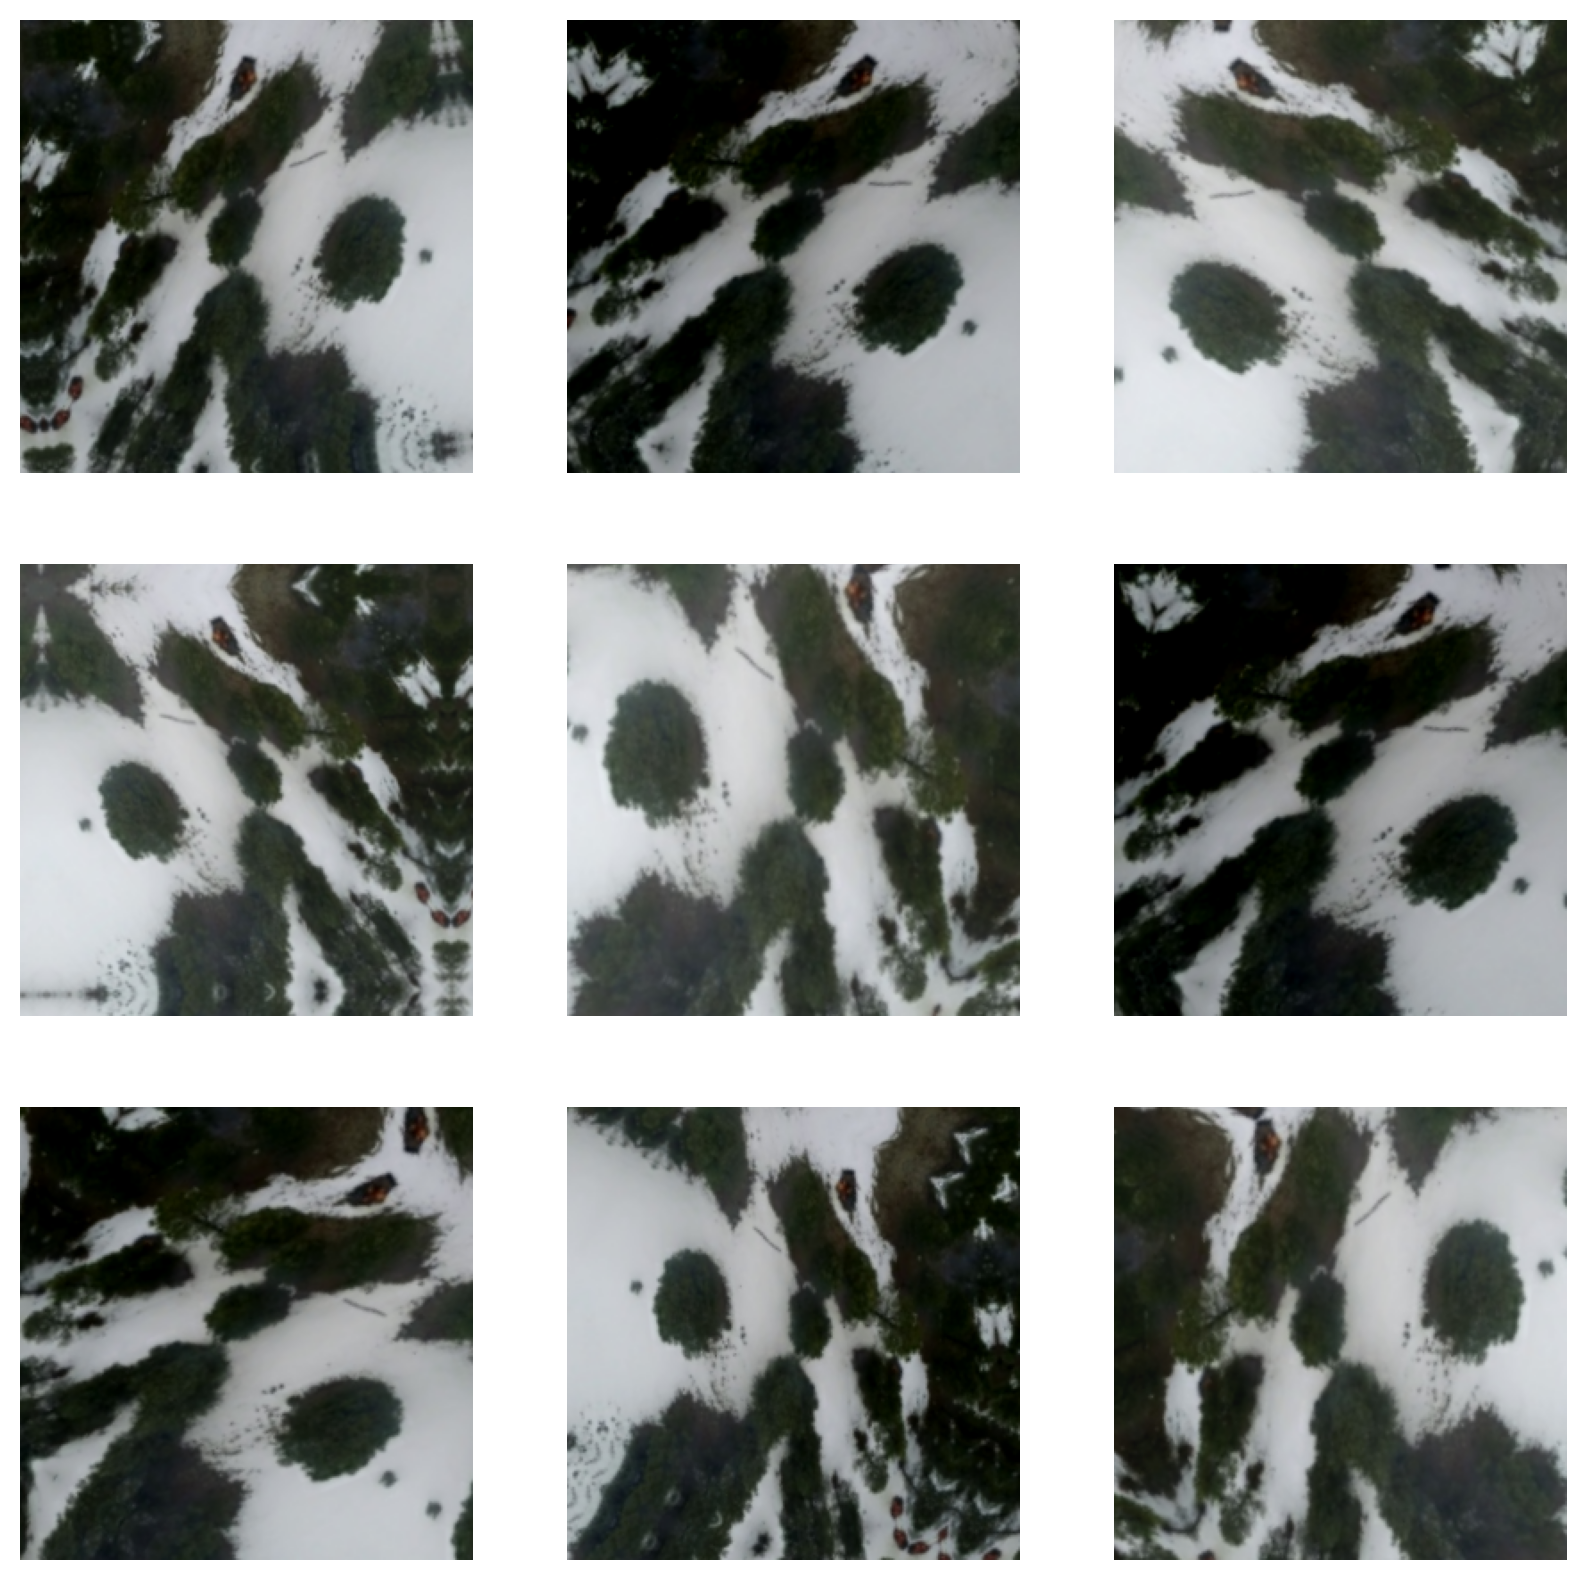

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

The following mode is too complicated to run on my machine so I used a simpler one.

In [ ]:
#def make_model(input_shape, num_classes):
#    inputs = keras.Input(shape=input_shape)
#
#    # Entry block
#    x = layers.Rescaling(1.0 / 255)(inputs)
#    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#    x = layers.BatchNormalization()(x)
#    x = layers.Activation("relu")(x)
#
#    previous_block_activation = x  # Set aside residual
#
#    for size in [256, 512, 728]:
#        x = layers.Activation("relu")(x)
#        x = layers.SeparableConv2D(size, 3, padding="same")(x)
#        x = layers.BatchNormalization()(x)
#
#        x = layers.Activation("relu")(x)
#        x = layers.SeparableConv2D(size, 3, padding="same")(x)
#        x = layers.BatchNormalization()(x)
#
#        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
#
#        # Project residual
#        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#            previous_block_activation
#        )
#        x = layers.add([x, residual])  # Add back residual
#        previous_block_activation = x  # Set aside next residual
#
#    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#    x = layers.BatchNormalization()(x)
#    x = layers.Activation("relu")(x)
#
#    x = layers.GlobalAveragePooling2D()(x)
#    if num_classes == 2:
#        units = 1
#    else:
#        units = num_classes
#
#    x = layers.Dropout(0.25)(x)
#    # We specify activation=None so as to return logits
#    outputs = layers.Dense(units, activation=None)(x)
#    return keras.Model(inputs, outputs)
#
#
#model = make_model(input_shape=image_size + (3,), num_classes=2)
#print(model.summary())#

In [ ]:
# Define CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(254, 254, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    #layers.Conv2D(128, (3,3), activation='relu'),
    #layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 252, 252, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     7,872,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,891,969 (30.11 MB)

 Trainable params: 7,891,969 (30.11 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
#model.compile(
#    optimizer=keras.optimizers.Adam(3e-4),
#    loss=keras.losses.BinaryCrossentropy(from_logits=True),
#    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
#)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.6350 - loss: 36.8828 - val_accuracy: 0.9329 - val_loss: 0.3919
Epoch 2/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.6194 - loss: 0.6699 - val_accuracy: 0.6375 - val_loss: 0.6685
Epoch 3/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.6407 - loss: 0.6788 - val_accuracy: 0.6375 - val_loss: 0.6579
Epoch 4/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.6365 - loss: 0.6575 - val_accuracy: 0.6375 - val_loss: 0.6555
Epoch 5/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.6362 - loss: 0.6560 - val_accuracy: 0.6375 - val_loss: 0.6550


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    "fireNoFire/Test",
    #labels="inferred",
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Typically, you don't shuffle the test dataset
)

Found 8617 files belonging to 2 classes.


In [ ]:


results = model.evaluate(test_ds, verbose=1, batch_size=batch_size)
print("test loss, test acc:", results)

68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.8942 - loss: 0.5194
test loss, test acc: [0.6758013367652893, 0.597191572189331]


This starting model has very poor accuracy.



## PCA components

## Maybe use only green part of data or something


## Trying a pre-trained model EfficientNet


In [ ]:
from keras.applications import EfficientNetB1

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 240
BATCH_SIZE = 64
size = (IMG_SIZE, IMG_SIZE)

batch_size = 128



effi_ds_train = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
effi_ds_val = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))
effi_ds_test = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))


In [ ]:
def build_model_efficientNet(num_classes=1):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB1(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
model = build_model_efficientNet(1)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(effi_ds_train, epochs=epochs, validation_data=effi_ds_val, verbose=1)
plot_hist(hist)

Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.9593 - loss: 0.1141 - val_accuracy: 0.9694 - val_loss: 0.0667
Epoch 2/25
127/262 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.9853 - loss: 0.0486

KeyboardInterrupt: 

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)